In [1]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
import matplotlib.pyplot as plt

In [2]:
wine = pd.read_csv("Documents/winemag-data_first150k.csv")

In [3]:
wine = wine.drop(['winery', 'region_1', 'region_2', 'designation'], axis=1)

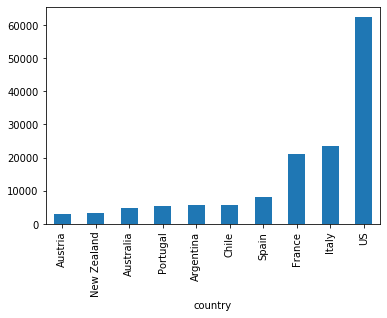

In [4]:
wine2 = wine.reset_index().groupby(['country'])['country'].count().sort_values().tail(10)
wine2.plot(kind='bar')
#sorting the wine counts by region, you can see that US is highest producing by a large amount

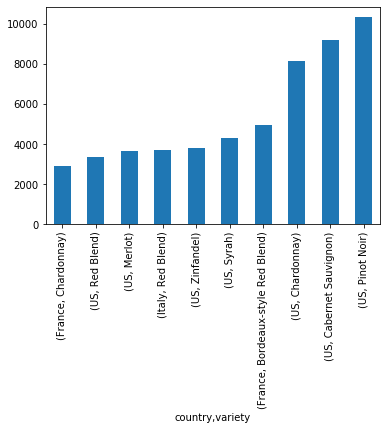

In [5]:
wine2 = wine.reset_index().groupby(['country', 'variety'])['country'].count().sort_values().tail(10)
wine2.plot(kind='bar')
#added in variety to see top wine types per regions - can see that pinot noir, cab sauv, and chardonnary are top from us. 
#france top wine is bordeaux 

In [6]:
wine = wine.dropna(subset = ['country', 'province'])
#can now see that only nans are price, which there are quite a few entries for. need to check further

In [7]:
wine['price'] = wine['price'].fillna(wine.groupby('variety')['price'].transform('mean'))
#fill nan values from the price column with mean price per variety - think this will be more accurate than just using a blanket mean 

In [8]:
wine = wine.dropna(subset = ['price'])
#can see that all NANs are removed from dataset 

In [9]:
#starting nlp section of EDA - going to play around with tokenization to see what results I get. also going to generate word clouds
import nltk.corpus
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from collections import Counter
text = wine['description'].to_string()
tokens = [w for w in word_tokenize(text.lower())if w.isalpha()]

In [10]:
rem_words = ["wine", "aromas", "blend"]
stops = set(stopwords.words("english") + rem_words)
wine_words = [w for w in tokens if not w in stops]
#removed wine, aromas, ripe, blend, and fruit as stop words and can see nose, rich, dry, soft, sweet are comming up  - 
#think it might be good to look at a wordcloud to get a large overview of words. 

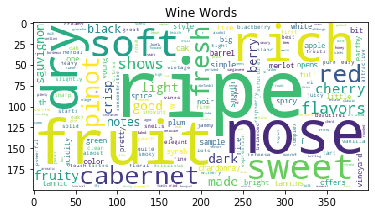

In [11]:
from wordcloud import WordCloud
wine_count = Counter(wine_words)
wc = WordCloud(background_color='white').generate_from_frequencies(wine_count)
plt.title("Wine Words")
plt.imshow(wc)
#made a word cloud of top words to see a larger picture - this is not focusing on specific varieties. Can see that nose, rich, dry
#are very popular. Soft, sweet, fresh cabernet are other wines. Need to remove other words such as shows, made, good, flavors to pick
#out the true descriptive words

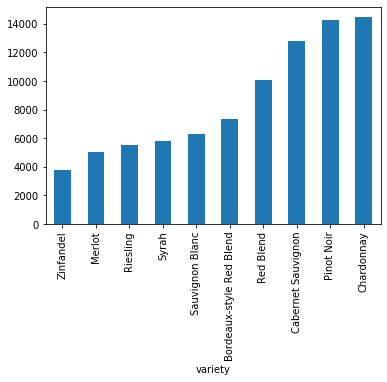

In [12]:
#lets look at top varieties and see if we can pull out most descriptive words
wine3 = wine.reset_index().groupby(['variety'])['variety'].count().sort_values()
wine3.tail(10).plot(kind='bar')
#can see that chardonnary and pinot noir are most popular - let's look at those descriptive words

In [13]:
chard = wine[wine.variety == 'Chardonnay']
chard_text = chard['description'].to_string()
tokens = [w for w in word_tokenize(chard_text.lower())if w.isalpha()]

In [14]:
chard_rem = ['nose', 'rich', 'shows', 'sweet', 'soft', 'flavors', 'chardonnay']
stops = set(stopwords.words("english") + chard_rem + rem_words)
chard_words = [w for w in tokens if not w in stops]
#so looking at top words, can see rich, chard, oak, nose, and apple - this is showing more descriptive words, which is good

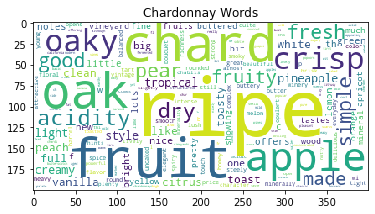

In [15]:
#chardonnay word cloud
chard_count = Counter(chard_words)
wc = WordCloud(background_color='white').generate_from_frequencies(chard_count)
plt.title("Chardonnay Words")
plt.imshow(wc)
#word cloud is helping to show more trends in words, can see some descriptive words stand out like oak and apple
#may want to remove words like nose, rich, swee, soft as these are pretty generic 

In [16]:
#want to recreate the same steps for pinot noir which is the next popular wine type to see how the words differ - this is
#important to see if the descriptive words can be used to predict wine type
pinot = wine[wine.variety == 'Pinot Noir']
pinot_text = pinot['description'].to_string()
tokens = [w for w in word_tokenize(pinot_text.lower())if w.isalpha()]

In [17]:
pinot_rem = ['pinot', 'noir', 'good', 'vineyard', 'acidity', 'made']
stops = set(stopwords.words("english") + chard_rem + rem_words + pinot_rem)
pinot_words = [w for w in tokens if not w in stops]
Counter(pinot_words).most_common(10)
#so looking at top words, can see pinot and noir are coming up - need to remove them - let's create a word cloud to see if anything else should be removed

[('dry', 723),
 ('cherry', 716),
 ('ripe', 690),
 ('fruit', 583),
 ('light', 535),
 ('red', 410),
 ('silky', 369),
 ('raspberry', 363),
 ('one', 354),
 ('big', 347)]

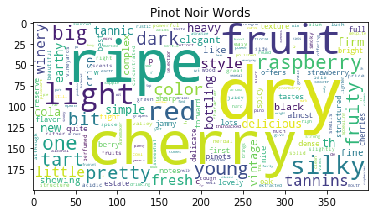

In [18]:
#pinot noir word cloud
pinot_count = Counter(pinot_words)
wc = WordCloud(background_color='white').generate_from_frequencies(pinot_count)
plt.title("Pinot Noir Words")
plt.imshow(wc)
#so can definitely see pinot noir neds to be removed, also need to remove good, acitiy, vineyard - i'm going to keep dry for now
#because i know this variety is a dry wine and may be somewhat descriptive 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

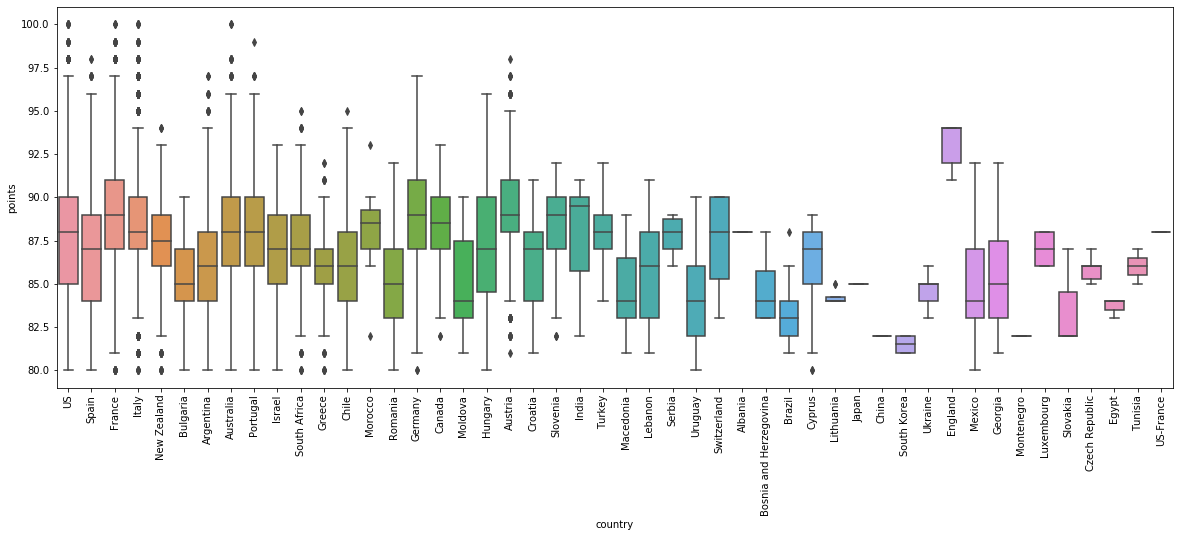

In [19]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='points', data=wine, ax=ax)
plt.xticks(rotation = 90)
#wanted to do some comparison on points distributions for regions as this might be good to model along with the descriptions
#can see that US, France, and Italy have high ranking wines but also dont have necessarily high means

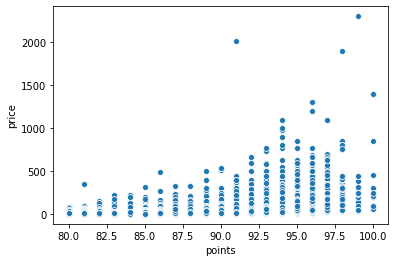

In [20]:
#also wanted to compare the points and prices to see if there is a correlation since I will need to do start some statisitcal testing
sns.scatterplot(y='price', x='points', data=wine)
#hard to tell if there is a correlation based on the outliers (there is a bottle wine priced at 2500), I'm going to remove 
#anything priced over 100 and re-graph

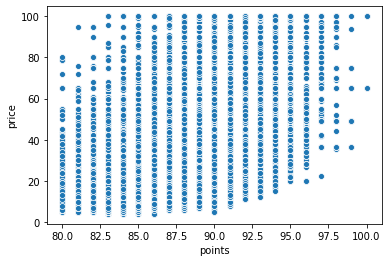

In [21]:
wine_scat = wine[wine.price <= 100]
sns.scatterplot(y='price', x='points', data=wine_scat)
#removing the outliers for price, we can see that there is a correlation between points and price so may be good to model

In [22]:
#want to look at the word cloud/ tokens for another popular variety (cab sauv)
cab_sauv = wine[wine.variety == 'Cabernet Sauvignon']
cab_text = cab_sauv['description'].to_string()
tokens = [w for w in word_tokenize(cab_text.lower())if w.isalpha()]

In [23]:
cab_rem = ['cabernet', 'cab', 'sauvignon']
stops = set(stopwords.words("english") + chard_rem + rem_words + pinot_rem + cab_rem)
cab_words = [w for w in tokens if not w in stops]
Counter(cab_words).most_common(10)
#so similar to the above wines, need to remove the cab/ cabernet

[('ripe', 694),
 ('dry', 687),
 ('fruit', 535),
 ('black', 451),
 ('cherry', 442),
 ('tannic', 420),
 ('blackberry', 416),
 ('tannins', 387),
 ('dark', 351),
 ('bit', 312)]

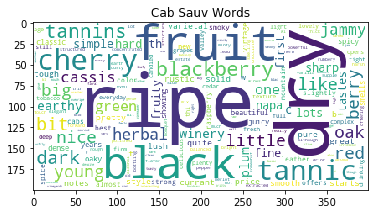

In [24]:
cab_count = Counter(cab_words)
wc = WordCloud(background_color='white').generate_from_frequencies(cab_count)
plt.title("Cab Sauv Words")
plt.imshow(wc)
#word cloud for cab sauv shows nice display, can also see herbal, jammy, plum, earthy are other big words 

In [25]:
#after performing preprocessing on the wine words - i'm going to put all of the steps together to create a cleaned list of words
#from the wine description set - from there, I can split up into top varieties like I did previously
rem_words = ["wine", "blend", "pinot", "chardonnay"]
stops2 = set(stopwords.words("english") + rem_words)
text = wine['description'].to_string()
tokens = [w for w in word_tokenize(text.lower())if w.isalpha()]
cleaned_wine = [w for w in tokens if not w in stops2]

In [26]:
#lemmatizing step
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer
ps = PorterStemmer()
cleaned_output = [lemmatizer.lemmatize(w) for w in cleaned_wine]

In [27]:
#stemming step
cleaned_output = [ps.stem(w) for w in cleaned_output]

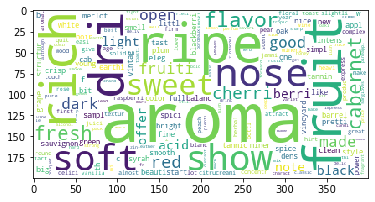

In [28]:
cleaned_count = Counter(cleaned_output)
wc = WordCloud(background_color='white').generate_from_frequencies(cleaned_count)
plt.imshow(wc)
#looking at the word cloud, there are some words that may want to consider removing due to vagueness such as aroma, rich, ripe
#soft, show, cabernet - these are not very descriptive and may pose problems once modeling. 
#also may want to perform pre-processing steps on popular varietals like chardonnay and pinot noir to perform modeling on them 
#to get variety specific data

In [29]:
#going to use lambda functions because need to add these descriptions back into original dataset for analysis
import re
wine['description']= wine['description'].str.lower()
wine['description']= wine['description'].apply(lambda elem: re.sub('[^a-zA-Z]',' ', elem))

In [30]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
wine_descriptions = wine['description'].apply(tokenizer.tokenize)
wine_descriptions.head()

0    [this, tremendous, varietal, wine, hails, from...
1    [ripe, aromas, of, fig, blackberry, and, cassi...
2    [mac, watson, honors, the, memory, of, a, wine...
3    [this, spent, months, in, new, french, oak, an...
4    [this, is, the, top, wine, from, la, b, gude, ...
Name: description, dtype: object

In [31]:
stopword_list = stopwords.words('english')
ps = PorterStemmer()
wine_descriptions = wine_descriptions.apply(lambda elem: [word for word in elem if not word in stopword_list])
wine_descriptions = wine_descriptions.apply(lambda elem: [ps.stem(word) for word in elem])
wine['description_cleaned'] = wine_descriptions.apply(lambda elem: ' '.join(elem))
#the description cleaned column can be used now for inferential stats  and modeling

In [32]:
#based on the course work, I can train supervised learning models using my bag of words data or tf-idf. since I created bag of words
#I think I will use those models 
#inferential stat section - since I saw that points and price seemed pretty correlated, going to run some stats on this
cov_matrix = np.cov(wine['price'], wine['points'])
wine_cov = cov_matrix[0,1]
print(wine_cov)
#covariance shows these variables are related although not as strongly as expected

50.8075962297653


In [33]:
from scipy.stats import linregress
linregress(wine['price'], wine['points'])
#getting some summary stats from linregress, we can see the r-value is .45 so these variables are moderately correlated

LinregressResult(slope=0.04159286025495854, intercept=86.49342803018081, rvalue=0.45112003306666804, pvalue=0.0, stderr=0.00021182125388657626)

In [34]:
#pearson coefficient
from scipy import stats
stats.pearsonr(wine['price'], wine['points'])

(0.4511200330666678, 0.0)

In [35]:
#spearman coefficient
stats.spearmanr(wine['price'], wine['points'])
#we see that the spearman coefficient is the highest at .587

SpearmanrResult(correlation=0.587909821009001, pvalue=0.0)

In [36]:
#going to do some poisson distributions focused on wine price - going to adjust the points to see the difference
wine_mean = np.mean(wine['price'])
wine_pois = np.random.poisson(wine_mean, size=10000)
print(wine_mean)
#so the mean price of all wines - 33.5

33.54365718268387


In [37]:
print(np.mean(wine_pois)) 
#the poisson distribution also returned a mean of 33.5

33.551


In [38]:
#let's look at the price for wines that have a point 90 and greater to see the difference
wine_great = wine[wine.points >= 90]
wine_great = wine_great['price']
wine_great_mean = np.mean(wine_great)
print(wine_great_mean)
#the mean price for wines 90 points and higher is 52.7, so considerably higher

52.71096624716112


In [39]:
wine_great_pois = np.random.poisson(wine_great_mean, size=10000)
print(np.mean(wine_great_pois))
#we can see the mean of the poisson distribution is very similiar 

52.7754


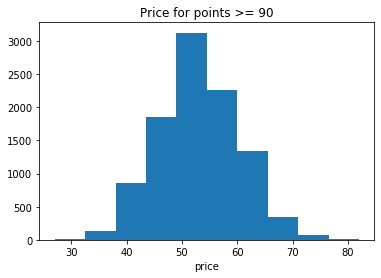

In [40]:
_ = plt.hist(wine_great_pois)
_ = plt.xlabel("price")
_ = plt.title("Price for points >= 90")
plt.show()
#we can see looking at the poisson distribution that the maority is between closely centered around that 45 - 62 range

In [41]:
#wanted to compute PMF/ ECDF for the wines with points over 90 but am getting a very large STD - i'm going to remove outlier
wine_great_mean = np.mean(wine_great)
wine_std = np.std(wine_great)
wine_dist = np.random.normal(wine_great_mean, wine_std, size=10000)

C:\Users\lacey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


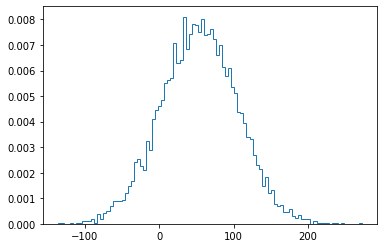

In [42]:
_ = plt.hist(wine_dist, normed=True, histtype='step', bins=100)
#you can see the data is coming out odd since the STD is so high - we have some negative numbers so need to remove outliers

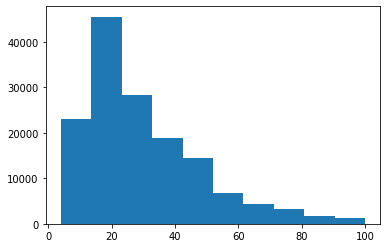

In [43]:
wine6 = wine[wine.price <= 100]
_ = plt.hist(wine6['price'])
plt.show()
#distribution looks better but still some outlies beyond 100

In [44]:
#performing random distribution 
wineg = wine[wine.points >= 90]
wineg = wine[wine.price <=500]
wineg = wine['price']
wine_great_mean6 = np.mean(wineg)
wine_std6 = np.std(wineg)
wine_dist6 = np.random.normal(wine_great_mean6, wine_std6, size=10000)

C:\Users\lacey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


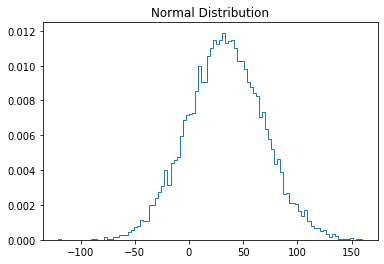

In [45]:
_ = plt.hist(wine_dist6, normed=True, histtype='step', bins=100)
_ = plt.title("Normal Distribution")

In [46]:
#going to also do some bootstrapping of the prices greater than 90 since the data is so widespread
Replications = np.array([np.random.choice(wine_great, len(wine_great), replace = True) for _ in range(10000)])
Mean = np.mean(Replications, axis=1)
conf_int = np.percentile(Mean, [2.5, 97.5])
print(conf_int)
#we can see after bootstrapping that the confidence is 52.2 to 53.2

[52.24620712 53.17454001]


In [47]:
#ANOVA test doing first one on price and variety
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
results = ols('price ~ variety', data=wine).fit()
#print(results.summary())

In [48]:
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table
#so looking at the OLS table - the r**2 is pretty low .110 so doesnt seem to correlated - also looking at the annova summary table 
#sum of squares is very low and variance is high. probablity is also low

,sum_sq,df,F,PR(>F)
variety,2.023507e+07,618.0,29.986353,0.0
Residual,1.640999e+08,150285.0,NaN,NaN


In [49]:
#lets try looking at different factors such as points and province to see if these are related
results2 = ols('points ~ province', data=wine).fit()

In [50]:
aov_table2 = sm.stats.anova_lm(results2, typ=2)
aov_table2
#so it actually looks like these are less correlated 

,sum_sq,df,F,PR(>F)
province,1.966595e+05,454.0,47.558573,0.0
Residual,1.370312e+06,150449.0,NaN,NaN


In [51]:
results3 = ols('points ~ variety', data=wine).fit()

In [52]:
aov_table3 = sm.stats.anova_lm(results3, typ=2)
aov_table3

,sum_sq,df,F,PR(>F)
variety,1.574639e+05,618.0,27.166948,0.0
Residual,1.409508e+06,150285.0,NaN,NaN


Pearson Correlation: (0.4511200330666678, 0.0)
                                 OLS Regression Results                                
Dep. Variable:                 points   R-squared (uncentered):                   0.495
Model:                            OLS   Adj. R-squared (uncentered):              0.495
Method:                 Least Squares   F-statistic:                          1.482e+05
Date:                Fri, 27 Mar 2020   Prob (F-statistic):                        0.00
Time:                        14:47:30   Log-Likelihood:                     -8.3806e+05
No. Observations:              150904   AIC:                                  1.676e+06
Df Residuals:                  150903   BIC:                                  1.676e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0

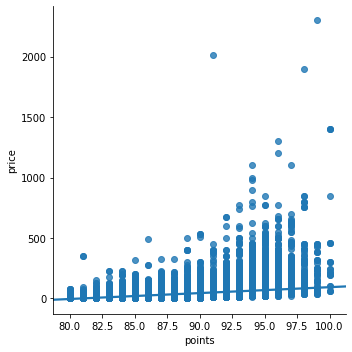

In [53]:
#let's see how price and points are correlated
from scipy.stats import pearsonr
print("Pearson Correlation:", pearsonr(wine.price, wine.points))
print(sm.OLS(wine.points, wine.price).fit().summary())
sns.lmplot(y = 'price', x='points', data=wine)
#we can see nice correlation between price and points - .495 r squared

In [54]:
#when trying to run ANOVA test on description_cleaned - getting memory error - need to see how to work around this
#created bag of words but cant run anova with that as not part of dataset
#lets use count vectorizer along with train test split to see if description can be used to predict variety
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
y = wine['variety']
X_train, X_test, y_train, y_test = train_test_split(wine['description'], y, test_size=0.33, random_state=53)

In [55]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values) 

In [56]:
#lets see how predictive this is 
from sklearn.naive_bayes import MultinomialNB 
from sklearn import metrics
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, pred)
#can see accuracy score is 53% based on classifier used comparing wine description to variety - decent score right off the bat

0.5341472720335749

In [57]:
#lets stry to run same naives bayes model on the cleaned description column I created to see if that increases the accuracy
X_train, X_test, y_train, y_test = train_test_split(wine['description_cleaned'], y, test_size=0.33, random_state=53)
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

In [58]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, pred)
#we can see the accuracy score increased slightly using the stemmed/ pre-processed data

0.539910439968674

In [59]:
#modeling with NB is pretty good with cleaned column created - variety and description have a good relationship - need to see what
#modeling can be done with the bag of words I have created - also may want to do some linear regressions on points and price as they 
#had a strong correlation
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
x = wine['points']
y = wine['price']
x = x.values.reshape(-1,1)
y = y.values.reshape(-1,1)
x = preprocessing.scale(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
LN = LinearRegression()
LN.fit(X_train, y_train)
y_pred = (LN.predict(X_test))
r2_score(y_test, y_pred)
#looking at the linear regression for points and price, they have a fairly low r**2 but seems like price outliers are throwing off
#going to remove and re-run

0.19730547232986761

In [60]:
#re-running regression with price outliers removed
x = wine6['points']
y = wine6['price']
x = x.values.reshape(-1,1)
y = y.values.reshape(-1,1)
x = preprocessing.scale(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
LN = LinearRegression()
LN.fit(X_train, y_train)
y_pred = (LN.predict(X_test))
r2_score(y_test, y_pred)
#I can see that removing outliers has increased R**2 - could still remove some outliers as seems majority are not over 100 USD 

0.2959810954689801

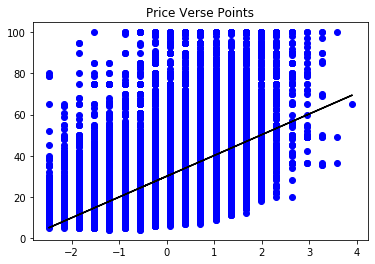

In [61]:
plt.scatter(X_test, y_test, color ='b') 
plt.plot(X_test, y_pred, color ='k') 
plt.title("Price Verse Points")
plt.show()

In [62]:
#running the naives bayes classifier, I saw that description is correlated to variety - lets see if the description is correlated
#to other features such as points/ price
y = wine['points']
X_train, X_test, y_train, y_test = train_test_split(wine['description_cleaned'], y, test_size=0.33, random_state=53)
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

In [63]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, pred)
#so the accuracy is not so high between description and points 

0.28424265547500954

In [64]:
#let's see if there is a relationship between the top three wine variety points and description to see if that improves the model
wine_update3 = wine.set_index('variety').loc[['Chardonnay', 'Pinot Noir', 'Cabernet Sauvignon']]
wine_update3 = wine_update3.reset_index()
y = wine_update3['points']
X_train, X_test, y_train, y_test = train_test_split(wine_update3['description_cleaned'], y, test_size=0.33, random_state=53)
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

In [65]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, pred)
#we can see that focusing on the top three varieties did improve the model

0.32298272468838835

In [66]:
#tried different ways of getting tfidf model to show values listed in ascending order, but not showing in matrix like desired
#going to try to vectorizer to see if that gets me a list that is cleaned 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(wine['description_cleaned'])

In [67]:
sums = matrix.sum(axis=0)
terms = vectorizer.get_feature_names()

data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False).head(15))
#was able to rank the result from ths tfidf model and can see top words are wine, flavor, fruit, acid, finish, cherry, tannin
#dry, aroma

         term         rank
21212    wine  6607.974903
7037   flavor  6081.029707
7492    fruit  5704.858899
114      acid  4220.534530
6929   finish  4132.519846
3593   cherri  4066.382630
18772  tannin  3682.020426
5705      dri  3639.322179
969     aroma  3569.457087
15781    ripe  3425.437289
5713    drink  3316.628154
18579   sweet  3269.112081
15698    rich  3179.861447
17746   spice  3152.848167
1916    black  3086.599578


In [68]:
wine['price_int'] = wine['price'].astype(np.int64)
#going to change the price category to int64 since I was able to succesfully model the points and description

In [69]:
y = wine['price_int']
X_train, X_test, y_train, y_test = train_test_split(wine['description_cleaned'], y, test_size=0.33, random_state=53)
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

In [70]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, pred)
#updating the dtype of price to int64, I was able to run through the model and can see score is very low so not a very strong relationship

0.16215185043876382

In [71]:
#the model of price verse description cleaned was not showing as a strong rleationship as model accuracy score is low - going 
#to remove some outliers (such as price) and see if that improves the model
wine_update = wine[wine.price <=100]
y = wine_update['price_int']
X_train, X_test, y_train, y_test = train_test_split(wine_update['description_cleaned'], y, test_size=0.33, random_state=53)
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

In [72]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, pred)
#limiting the price to 100 and below, we can see the model hardly improved 

0.16415579077176035

In [73]:
#going to try a couple of different model types rather than Naive Bayes to see if that improves score
from sklearn.ensemble import RandomForestRegressor
y = wine['points'].values
X_desc = wine['description_cleaned']
count_vectorizer = CountVectorizer(max_features = 1000)
count_vectorizer.fit(X_desc)
X_count = count_vectorizer.transform(X_desc)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_count, y, test_size=0.33, random_state=12)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test)
#ran model with random forest and got much higher score than NB - 70, which shows strong relationship between points and description
#going to also try different variables and see how that improves as well as may try tfidf

C:\Users\lacey\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7000364402825707

In [75]:
#going to try same RF model with price
y = wine['price_int'].values
X_train, X_test, y_train, y_test = train_test_split(X_count, y, test_size=0.33, random_state=12)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test)
#see that using the RF does not bring back a very high score from price and description, but did improve the model from NB

C:\Users\lacey\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.3035782860152738

In [76]:
#going to try to use with TFIDF instead to see improvements matrix is our tfidf vectorizer
y = wine['points'].values
X_train, X_test, y_train, y_test = train_test_split(matrix, y, test_size=0.33, random_state=12)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test)
#running random forest with TFIDF vectorizer rathern than CountVectorizer, this marginally improved model 

C:\Users\lacey\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7080361534623911

In [77]:
#going to run with price instead of points to see if TFIDF vectorizer improves model
y = wine['price_int'].values
X_train, X_test, y_train, y_test = train_test_split(matrix, y, test_size=0.33, random_state=12)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test)
#ran price and desciprtion with the tfidf vectorizer but did not see an improvement in model from countvectorizer, but still
#performing better than NB 

C:\Users\lacey\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.32081802992493613

In [78]:
#going to try to remove outliers to see if that improves price model since quite disparity in price
wine_update = wine[wine.price <=100]
X_desc = wine_update['description_cleaned']
y = wine_update['price_int'].values
count_vectorizer = CountVectorizer(max_features = 1000)
count_vectorizer.fit(X_desc)
X_count = count_vectorizer.transform(X_desc)
X_train, X_test, y_train, y_test = train_test_split(X_count, y, test_size=0.33, random_state=12)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test)
#removing the outliers from the price column improved the model quite a bit, seems like much stronger relationship

C:\Users\lacey\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5510619387160423